## 라이브러리 로드

In [3]:
import os
import pandas as pd
import numpy as np

from hanspell import spell_checker
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Twitter
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

## 경로 지정

In [7]:
DATA_PATH_1 = f'data/data_genre/'

In [8]:
path = os.path.join(DATA_PATH_1, "melon_folkblues_인기_가사__12124.csv")
path
df= pd.read_csv(path)
df.shape

(12124, 4)

## Tf-idf

TF-IDF(Term Frequency-Inverse Document Frequency)는 단어의 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여

문서 단어 행렬 (Document-Term Matrix) 내의 단어들마다 중요한 정도를 가중치로 주는 방법입니다.

해당 지표를 통 가사에 활용하여 한 곡 내에서 어떤 단어들이 주로 등장하게 되는지 확인해 보도록 하겠습니다.

In [9]:
tfidf = TfidfVectorizer(max_features=500)
tdm = tfidf.fit_transform(df['가사'])

In [10]:
cv = CountVectorizer(max_features=500)
tdm2 = cv.fit_transform(df['가사'])

In [11]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    'tf-idf': tdm.sum(axis=0).flat
})

/Users/jihye/miniconda/envs/hello/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


어떤 단어가 높은 빈도로 등장하는 지 확인하도록 하겠습니다.

In [12]:
vocabs = word_count.sort_values('tf-idf', ascending=False)
top_30 = vocabs.head(30)
top_30.head()

,단어,tf-idf
87,나는,422.571437
98,내가,416.979526
49,그대,400.934262
93,나의,393.433936
110,너의,386.182274


대명사, 조사가 매우 많은 것을 확인할 수 있습니다.
다른 단어들의 분포 또한 확인하기 위해 Tf-idf 30위의 단어들에 대한 시각화를 진행합니다.

<AxesSubplot: xlabel='단어', ylabel='tf-idf'>

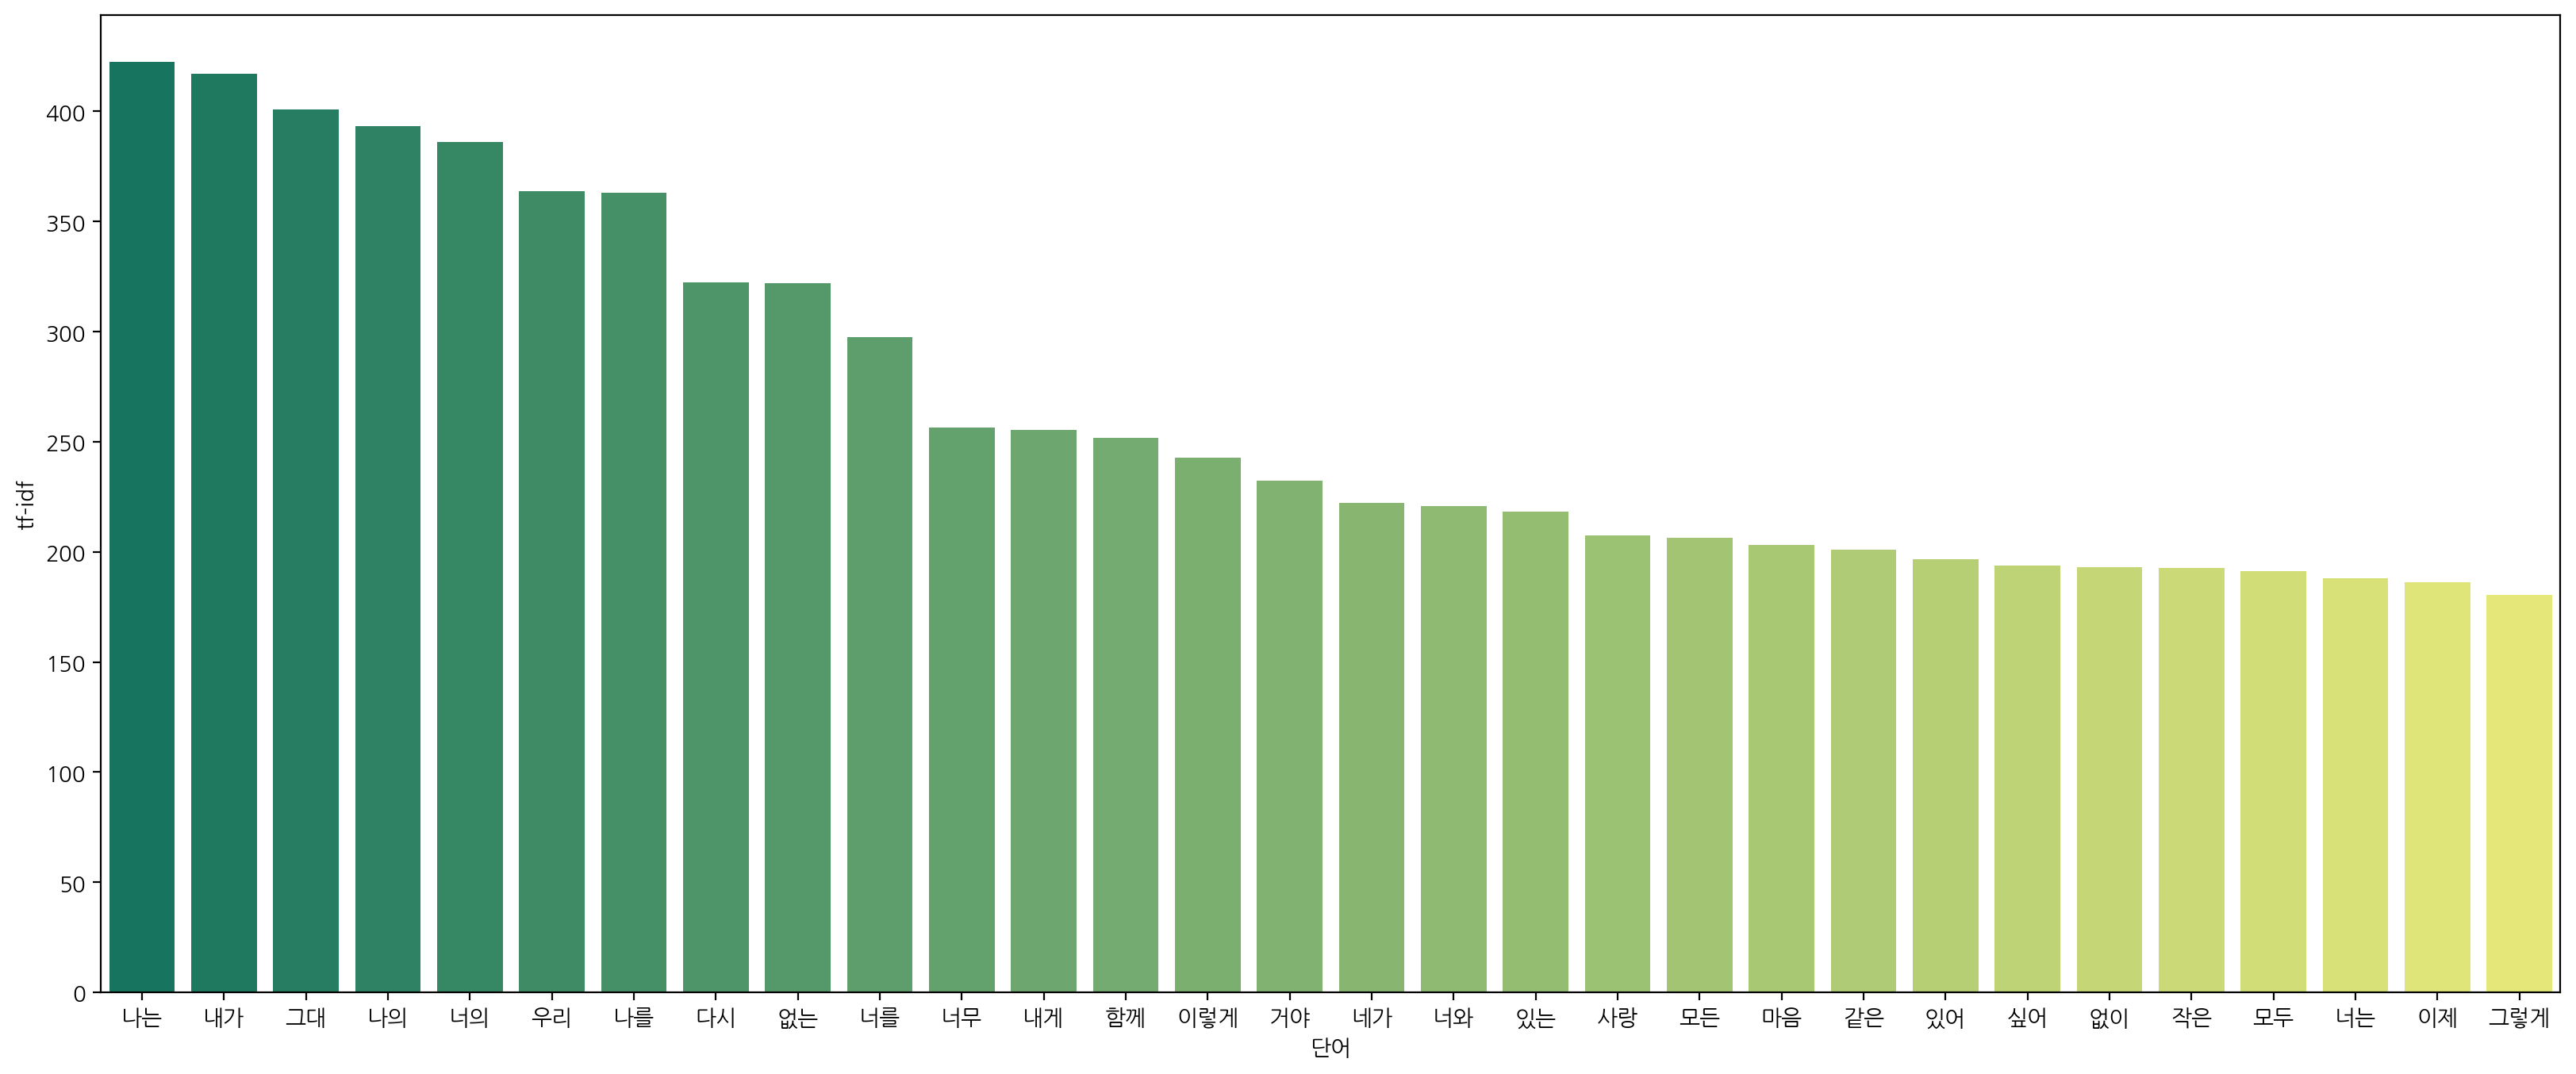

In [8]:
plt.figure(figsize=(20, 8))
sns.barplot(x="단어", y="tf-idf", data=top_30, palette='summer')

나와 상대를 지칭하는 표현들이 많은 것을 보아, 서로의 관계성에 대해 노래하거나 스스로의 감정을 표현하는 맥락이 많다는 것을 확인할 수 있습니다.

그러나 조사가 붙은 단어가 대부분이어서, 토크나이저를 활용하여 특정 형태소의 단어군을 추출할 필요가 있습니다.

## 명사 추출

형태소 분석을 위해 konlpy의 Okt 객체를 선언하여 사용하겠습니다.

Okt를 사용하면 띄어쓰기와 무관하게 명사만을 추출하게 됩니다.

In [14]:
# .csv 파일을 리스트로 만들어줍니다.

lst = []
for i in range(len(df["가사"])):
    for j in df["가사"].str.split("\n")[i]:
        lst.append(j)

In [16]:
# 리스트를 하나의 문자열로 연결해줍니다.
txt = '\n'.join(lst)

In [17]:
# 문자열을 okt 객체에 넣어, 가사에 사용된 명사들만을 추출합니다.
okt = Okt()
noun_lst = okt.nouns(txt)

In [18]:
# 명사로 이루어진 리스트들의 데이터 갯수를 카운트하여 딕셔너리로 반환합니다.
dict_noun = Counter(noun_lst).most_common(30)

In [19]:
df_noun = pd.DataFrame(dict_noun)
df_noun.columns=['단어', '빈도']
df_noun.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
단어,내,너,나,사랑,그대,그,말,날,우리,난,...,눈,오늘,속,더,생각,또,바람,다시,해,시간
빈도,23322,23179,20676,17571,13886,12342,12337,10560,9695,9071,...,5416,5247,5185,5147,4948,4508,4275,4211,4123,4121


대명사가 많이 사용되었음을 확인할 수 있습니다. function word의 다양성을 확인하기 위해, 대명사를 제거해준 결과도 한번 확인해보겠습니다.

In [20]:
filtered = []
stopwords = ['나', '난', '너', '넌', '널', '날', '우리' , '내', '네', '그런', 
            '이', '그', '그녀', '저', '것', '들', '제', '저희', '너', '그대']
for words in noun_lst:
    if words not in stopwords:
                filtered.append(words)

In [21]:
dict_noun_2 = Counter(filtered).most_common(30)

df_noun_2 = pd.DataFrame(dict_noun_2)
df_noun_2.columns = ['단어', '빈도']
df_noun_2.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
단어,사랑,말,수,마음,밤,사람,때,맘,눈,오늘,...,곳,걸,세상,손,하루,모습,하늘,하나,길,지금
빈도,17571,12337,8881,8305,6594,6249,5638,5515,5416,5247,...,3708,3602,3546,3453,3417,3384,3351,3334,3316,3264


<AxesSubplot: xlabel='빈도', ylabel='단어'>

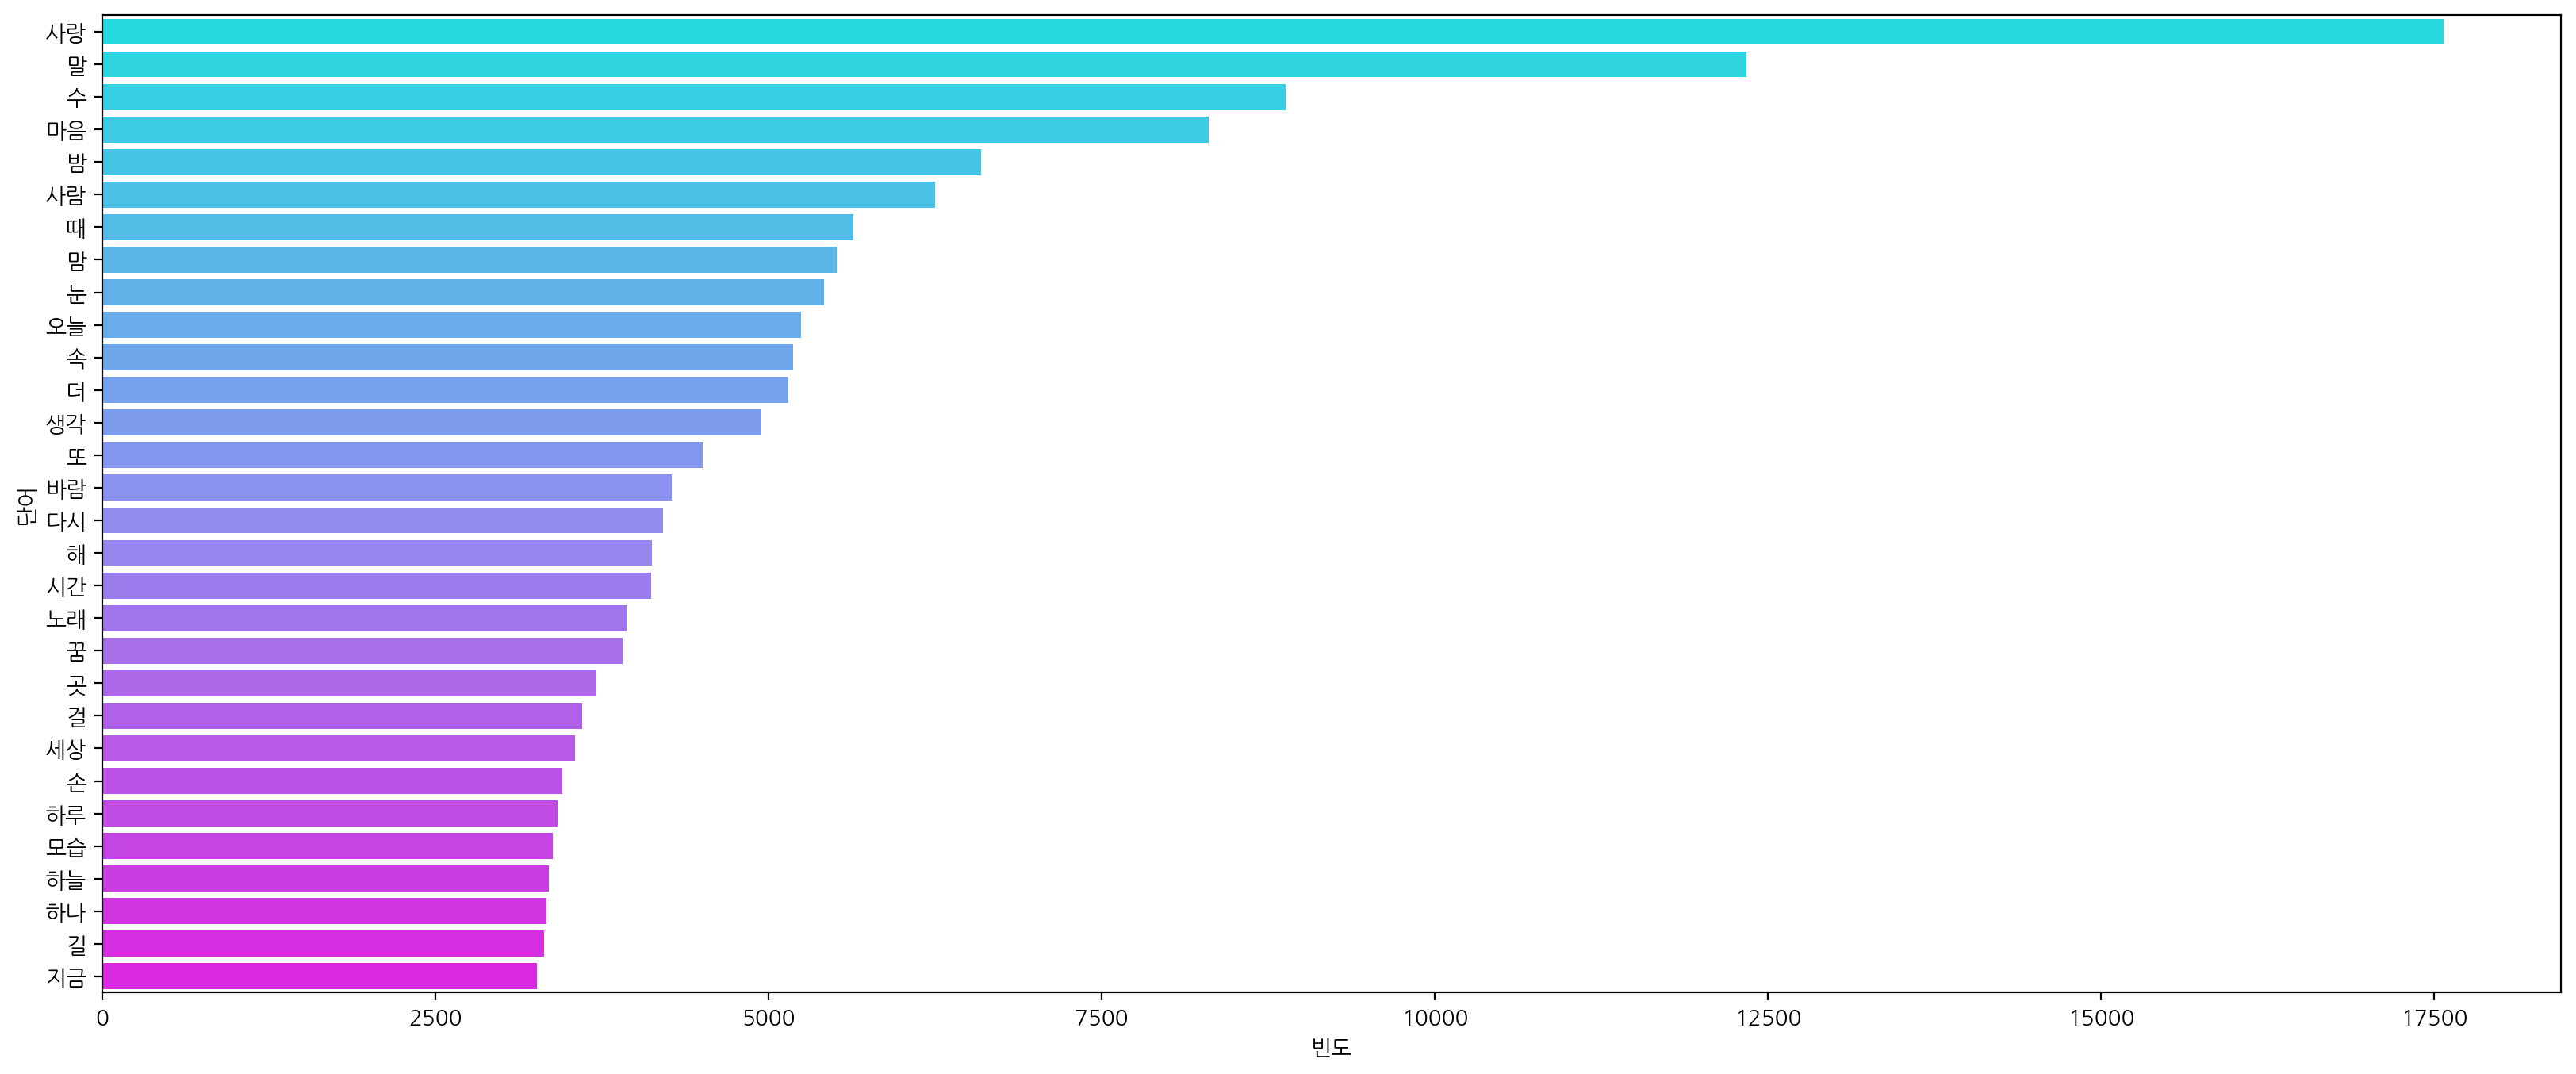

In [22]:
# 대명사를 제거한 빈도수를 확인합니다.

plt.figure(figsize=(20, 8))
sns.barplot(x="빈도", y="단어", data=df_noun_2, palette='cool')

결과를 확인하니 여전히 대명사가 많습니다. 또한 '해'와 같이 동사와 명사의 중의성을 띠는 단어가 발견되기도 합니다.

다른 토크나이저를 활용하여 명사를 추출하겠습니다.

In [23]:
# 메모리 부족 관계로 오류 발생

# from konlpy.tag import Kkma
# kkma = Kkma()
# noun_lst_2 = kkma.nouns(txt)

In [24]:
twt = Twitter()
tagging = twt.pos(txt)
tagging
twit_df = pd.DataFrame(tagging)

/Users/jihye/miniconda/envs/hello/lib/python3.10/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [26]:
twit_df.columns = ['단어', '품사']
twit_df.head()

,단어,품사
0,한층,Noun
1,더,Noun
2,높이,Noun
3,올라,Verb
4,있는,Adjective


In [86]:
twit_df = twit_df[twit_df['품사']=='Verb']
twit_count = pd.DataFrame(twit_df.groupby('단어')['품사'].count().sort_values(ascending=False))
twit_count = pd.DataFrame(twit_count.head(10).stack()).reset_index()
twit_count.columns=["단어", "class", "num"]
twit_count

,단어,class,num
0,해,품사,5158
1,나를,품사,5115
2,할,품사,4416
3,한,품사,3699
4,하는,품사,3346
5,내게,품사,3213
6,봐,품사,2802
7,싶어,품사,2552
8,하지,품사,1940
9,잘,품사,1926


In [67]:
# 토크나이저 사용 후 

tfidf_filtered = TfidfVectorizer(max_features=500)
tdm_filtered = twit_df.fit_transform(df_noun_2['단어'])

## 동사 추출

okt를 활용한 내용은 위와 같았습니다. 동사의 분포 또한 확인해보도록 하겠습니다.

삼행시를 제작하기 위해서는 다양한 동사의 분포를 확인해야 합니다.

유용하게 활용 될 수 있는 동사가 핵심 단어장에 적절하게 포함되어 있어야 하기 때문입니다.

okt 객체의 다른 형태소들을 분석해보기 위해서는 품사 태그를 따로 달아주어야 합니다.

In [56]:
okt = Okt()
word_lst = okt.pos(txt)

In [57]:
okt_df = pd.DataFrame(word_lst)
okt_df.columns=['단어', '품사']
okt_df = okt_df[okt_df['품사']=='Verb']
okt_df

,단어,품사
3,올라,Verb
15,흘러가는,Verb
22,부딪쳐요,Verb
31,춰요,Verb
41,올라,Verb
...,...,...
2058188,해,Verb
2058190,나도,Verb
2058193,적은,Verb
2058196,아냐,Verb


In [64]:
# 토큰화된 동사를 등장 횟수별로 분류

word_count = pd.DataFrame(okt_df.groupby('단어')['품사'].count().sort_values(ascending=False))
word_count

,품사
단어,
해,5158
나를,5115
할,4416
한,3699
하는,3346
...,...
전해진다면,1
전해진다,1
늦을까,1


## 가사 문장의 길이

In [ ]:
# apply, lambda를 통해 문자, 단어 빈도수 파생변수 만들기
df["word_count"] = df['가사'].map(lambda x : len(x.split())) # split을 공백 기준으로 나눔
df["unique_word_count"] = df['가사'].map(lambda x: len(set(x.split())))

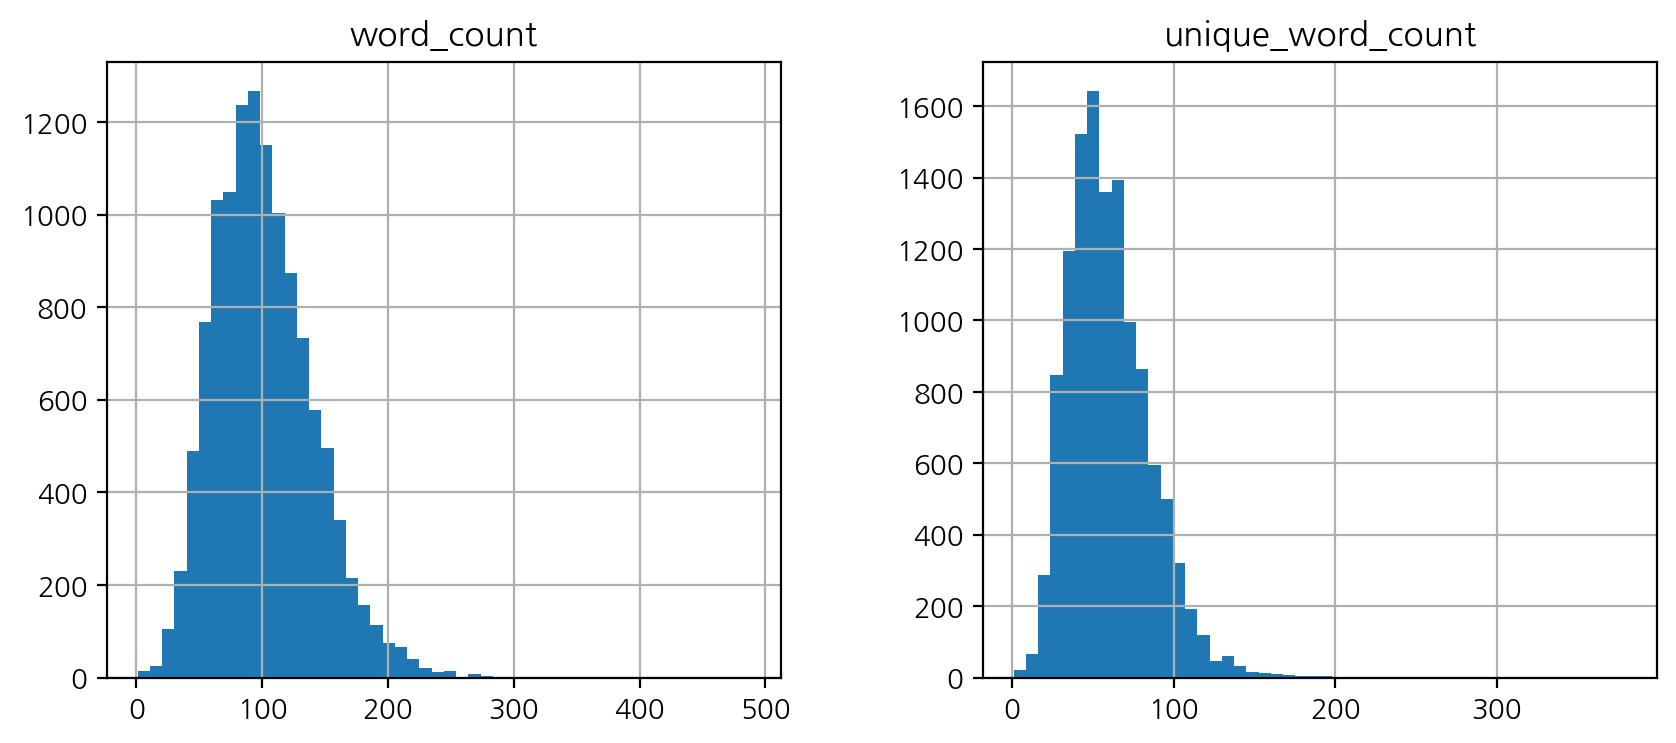

In [ ]:
df[['단어의 갯수', 'unique_word_count']].hist(figsize=(10, 4), bins=50);